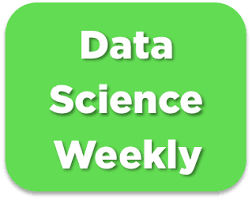

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, make_scorer
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [13]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


## Prétraitement des données et création d’un échantillon
Nous traiterons les outliers sur la variable 'age' et créerons un échantillon `data_sample` de 10 000 lignes, comme pour le modèle de base.


In [14]:
valeur_palier_haut = data['age'].mean() + 3*data['age'].std()
valeur_palier_bas = data['age'].mean() - 3*data['age'].std()
outlier_condition = (data['age'] > valeur_palier_haut) | (data['age'] < valeur_palier_bas)
data = data[~outlier_condition]
data_sample = data.sample(10000)

# Modele de Régression Logistique

## Création de la variable cible et des features

In [15]:
target_variable = 'converted'
features_list = data.drop(columns=[target_variable]).columns
numeric_indices = [0]
categorical_indices = []
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

### Feature convert2
Nous créons la variable `convert2`, qui convertit les données 0 et 1 en valeurs booléennes (False/True).  
Nous concaténons ensuite cette variable avec deux autres (`country` et `source`) afin de créer la variable `to_stratify`.

stratify = il sert à maintenir les mêmes proportions de classes (ou combinaisons de variables) dans train et test.

Ici, to_stratify sert à garantir que le split respecte la distribution conjointe de convert2, country et source, pour éviter un biais dans ton échantillon d’entraînement/test.
L’idée est que la répartition conjointe de ces trois variables (ex. utilisateur venant de tel pays, via telle source, et converti ou pas) soit équilibrée entre train et test.

Ainsi, Nous évitons que le jeu de test ait, par exemple, beaucoup de conversions dans un pays mais pas dans l’autre, ce qui fausserait la validation.


In [16]:

data['convert2'] = str(data['converted']>0)
to_stratify = data['country']+ data['convert2']+ data["source"] 


## Training pipeline

Nous créons notre pipeline de test en utilisant `stratify` comme paramètre dans `train_test_split`, afin de conserver les proportions des classes (spam / non-spam) dans le train et le test.  

Nous sélectionnons nos features numériques et catégorielles, et appliquons un prétraitement adapté :  
- Les features numériques sont standardisées avec `StandardScaler`.  
- Les features catégorielles sont encodées en one-hot avec `OneHotEncoder`.  

Nous ajustons ensuite les poids de classe dans la régression logistique (`class_weight`) pour donner plus de poids aux spams (valeur 1), car ils sont moins représentés dans le dataset. Après plusieurs essais manuels, ces paramètres ont montré les meilleurs résultats.  

Nous entraînons le modèle sur le train set et calculons le F1-score sur le train et le test.  

Enfin, nous réalisons une **cross-validation à 5 folds** pour vérifier que nos résultats sont cohérents avec différents découpages du dataset, et obtenir une estimation plus robuste du F1-score moyen.



In [17]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=to_stratify )


numeric_features = ['age','total_pages_visited', 'new_user']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

categorical_features = ['country', 'source']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

# Entraînement du modèle
classifier = LogisticRegression(class_weight={0:1, 1:1.59})
class_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier',classifier)])
class_pipeline.fit(X_train, Y_train)

# Prédictions
Y_train_pred = class_pipeline.predict(X_train)
Y_test_pred = class_pipeline.predict(X_test)

# Calcul F1-score
f1_train = f1_score(Y_train, Y_train_pred)
f1_test = f1_score(Y_test, Y_test_pred)
print(f"F1-score Train: {f1_train:.4f}, F1-score Test: {f1_test:.4f}")

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])
f1_scorer = make_scorer(f1_score)

cv_scores = cross_val_score(pipeline, X, Y, cv=cv, scoring=f1_scorer)

print(f"F1-score CV (5 folds) : {cv_scores}")
print(f"Moyenne F1-score CV : {cv_scores.mean():.4f}, Écart-type : {cv_scores.std():.4f}")

print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

F1-score Train: 0.7698, F1-score Test: 0.7705
F1-score CV (5 folds) : [0.77678828 0.7595582  0.77546427 0.77100959 0.76460579]
Moyenne F1-score CV : 0.7695, Écart-type : 0.0065
accuracy on training set :  0.9857997069034428
accuracy on test set :  0.9847656663257749


F1-score => Les scores sont très proches, ce qui indique :

Le modèle ne sur-apprend pas (pas d’overfitting notable).

Bonne capacité à généraliser sur de nouvelles données.

CV => 5 Folds
La faible variance (écart-type ~0.0065) montre que le modèle est stable, peu sensible à la répartition des données dans les folds.

La moyenne est très proche du F1-score test → cohérence avec le split train/test.

L'utilisation de l'accuracy est moins pertinente ici à cause du déséquilibre du dataset (seulement 3,23 % de taux de conversion).

Rappel : l’accuracy mesure simplement la proportion de prédictions correctes, mais elle peut être trompeuse sur des classes déséquilibrées.

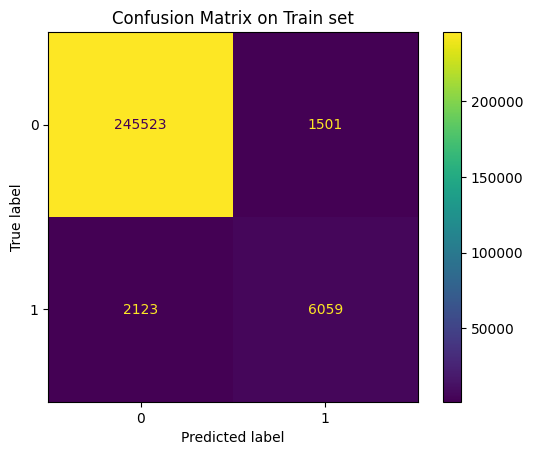

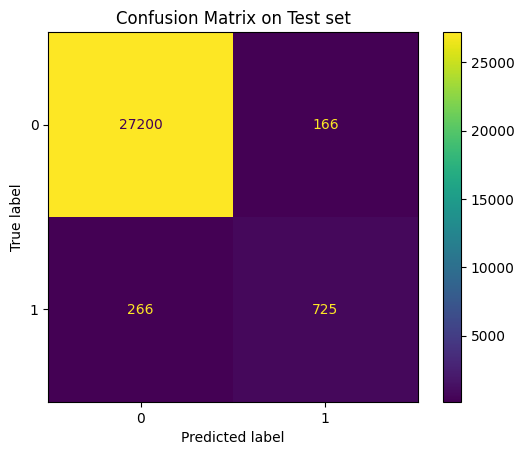

In [18]:
# Visualisation de la matrice de confusion
_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Train set"
)  
ConfusionMatrixDisplay.from_estimator(
    class_pipeline, X_train, Y_train, ax=ax
) 
plt.show()

_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Test set"
)  
ConfusionMatrixDisplay.from_estimator(
    class_pipeline, X_test, Y_test, ax=ax
)  
plt.show()


In [19]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))

print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))


Confusion matrix on train set : 
[[245523   1501]
 [  2123   6059]]
Confusion matrix on test set : 
[[27200   166]
 [  266   725]]


### Comparaison des résultats avec le modèle de base

* Vrais positifs (TP) :

Train : 6 059 vs 4 992 → +1 067 conversion détectés

Test : 725 vs 534 → +191 conversion détectés
Le nouveau modèle capture plus de conversion, donc le rappel s’améliore.

* Faux négatifs (FN) :

Train : 2 123 vs 3 268 → -1 145

Test : 266 vs 379 → -113
Moins de conversion passent entre les mailles du filet → meilleure sensibilité.

* Faux positifs (FP) :

Train : 1 501 vs 1 075 → +426

Test : 166 vs 120 → +46
Légère augmentation des faux positifs, mais encore faible → quelques conversion mal classées.

* Vrais négatifs (TN) :

Presque stable entre les deux modèles → le modèle continue de bien prédire les conversions.

#### Globalement le nouveau modèle surpasse le modèle de base sur la prédiction de conversion tout en conservant une bonne précision sur les conversion légitimes.

## Entraînement du modèle sur l’ensemble des données pour la prédiction finale
Avant de prédire sur conversion_data_test.csv, nous entraînons notre modèle sur toutes les données du train set (conversion_data_train.csv).

In [20]:
# On concatene notre ensemble d'entraînement et notre ensemble de test pour entraîner notre meilleur classificateur sur toutes les données avec étiquettes
X = pd.concat([X_train,X_test],axis=0)
Y = pd.concat([Y_train,Y_test],axis=0)

class_pipeline.fit(X,Y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Test de notre modèle sur le dataset de test sans labels 

Nous chargeons les données et sélectionnons les features utilisées par le modèle.

Nous appliquons le pipeline de prétraitement (preprocessor) pour transformer ces features de la même manière que pour le train set.

Nous utilisons le modèle entraîné (classifier) pour prédire la colonne converted.

Enfin, nous stockons les résultats dans un DataFrame et les exportons en CSV pour comparaison avec les véritables labels ultérieurement.

In [ ]:

data_without_labels = pd.read_csv('conversion_data_test.csv')

X_without_labels = data_without_labels.loc[:, features_list]

Y_pred = class_pipeline.predict(X_without_labels)

data = {'converted': Y_pred}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
# Y_predictions.to_csv('conversion_data_test_predictions_MARC-Reglog5.csv', index=False)